In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt

In [2]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [3]:
pars.set_matter_power(redshifts=[2], kmax=3.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [4]:
def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale

In [5]:
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [6]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

Derivata composta della distanza cìdi luminosità

dr/dz =  c/H

dl = (1+z)*r 

dl'= r + (1+z)*c/H

In [7]:
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!

f = (results.get_fsigma8()/results.get_sigma8())
dl = results.luminosity_distance(z[0])
d= results.comoving_radial_distance(z[0])
 

fl= (2*d)/(d+(1+z[0])*2.99e5/H(z[0]))

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati

In [8]:
#Set di dati simulati spettro di potenza delle galassie

Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = float((bias + fl *f * mu[j]**2)**2*pk[:,i])


In [9]:
#Dati per la funzione teorica

om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.8963052488262638

In [10]:
print(f)
print(fl)
print(fl*f)
print(omz**0.545)

[0.94612751]
1.0746737784749398
[1.01677843]
0.9420815252777087


In [11]:
##Errori dei dati simulati
ng= 15e-4   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol*1/(2*np.pi)**2 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)




In [12]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.03073494408317064

In [13]:
#faccio una trasformata di fuorier: considero il volume del guscio sferico come il volume di un cubo

Diag = np.sqrt(3) * (64)**(1/3)
2*np.pi/Diag

0.906899682117109

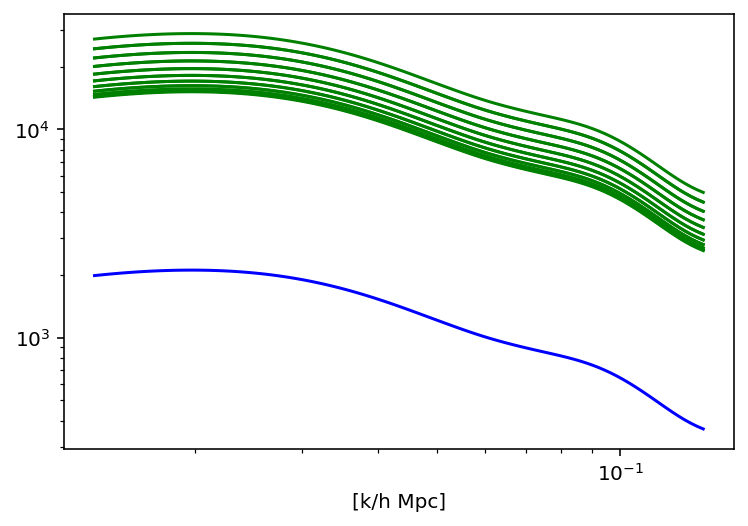

In [14]:
#Grafico

fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

#ax.legend(['matter','galaxy'], loc='lower left')
#plt.title('Total Matter power at z=%s and z= %s'%tuple(z));

[2541.83765487 2500.38159368 2458.70201714 2416.81012494 2374.71822542
 2332.43747656 2289.97830445 2247.35254038 2204.57345448 2161.65481055
 2118.61022378 2075.45467689 2032.20464401 1988.87745231 1945.48975421
 1902.0592856  1858.60531593 1815.14841966 1771.70932951 1728.30963008
 1684.9723136  1641.72167091 1598.58279258 1555.58153806 1512.74485098
 1470.10066688 1427.67826421 1385.50848468 1343.62272219 1302.05268964
 1260.8310222  1219.99313693 1179.5745879  1139.61017835 1100.1344354
 1061.18584184 1022.8035069   985.02422096  947.88263079  911.41665129
  875.66646824  840.66823387  806.45390935  773.05640678  740.51368349
  708.8584783   678.11728908  648.31325048  619.47386573  591.62186852
  564.77267747  538.93637338  514.12907165  490.36549355  467.65208593
  445.98776122  425.36059989  405.74936432  387.12956391  369.47434454
  352.76359587  336.99229145  322.15207143  308.22961558  295.19245437
  282.96535437  271.47286702  260.64709056  250.42636565  240.75444644
  231.5

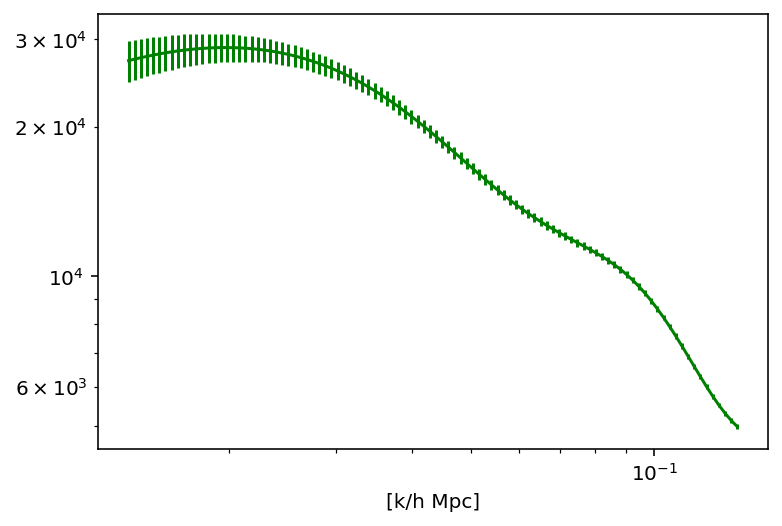

In [15]:
fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(kh, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-')  #aggiungi gli errori
print(err_Pgg[:,0])


In [20]:
gammas= np.arange(0.48,0.53,0.001)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma)*fl * (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2
        



Text(0, 0.5, 'Chi^2')

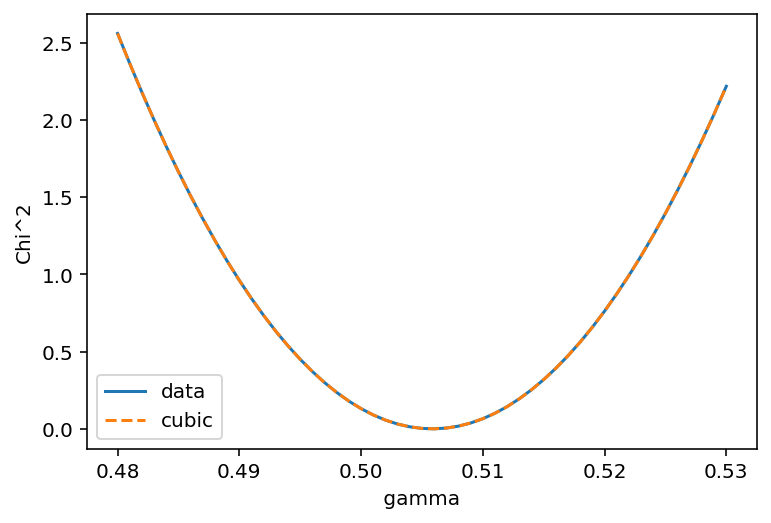

In [21]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])
plt.xlabel(' gamma ')
plt.ylabel('Chi^2')


#plt.axis([0.54,0.56,0,3])

In [22]:
type(interpol)
y=lambda x: interpol(x)


In [23]:

minimo = optimize.least_squares(y,0.5)
min1= float(minimo.x)
minimo

 active_mask: array([0.])
        cost: 7.766655183540617e-15
         fun: array([1.24632702e-07])
        grad: array([-5.43055629e-09])
         jac: array([[-0.04357248]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 11
        njev: 11
  optimality: 5.430556287733788e-09
      status: 1
     success: True
           x: array([0.50584778])

In [24]:
chi2min= y(min1)

In [25]:
min2= np.min(chi2)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min = np.argmin(chi2)
gamma_min = gammas[index_min]
gamma_min

0.506

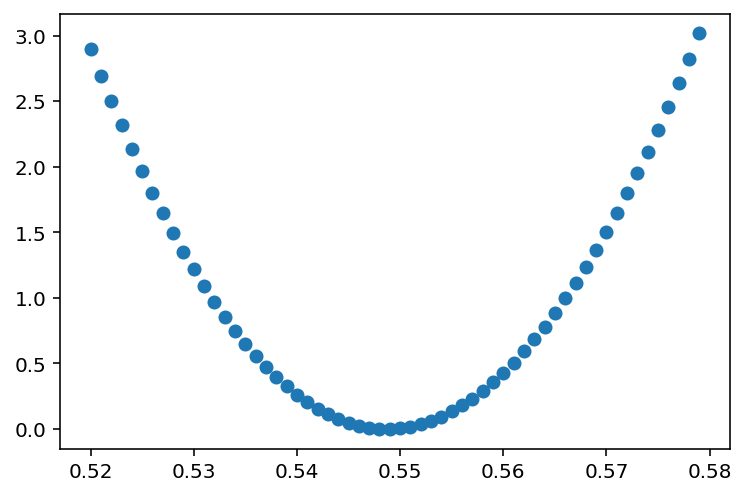

In [ ]:
plt.scatter(gammas,chi2)

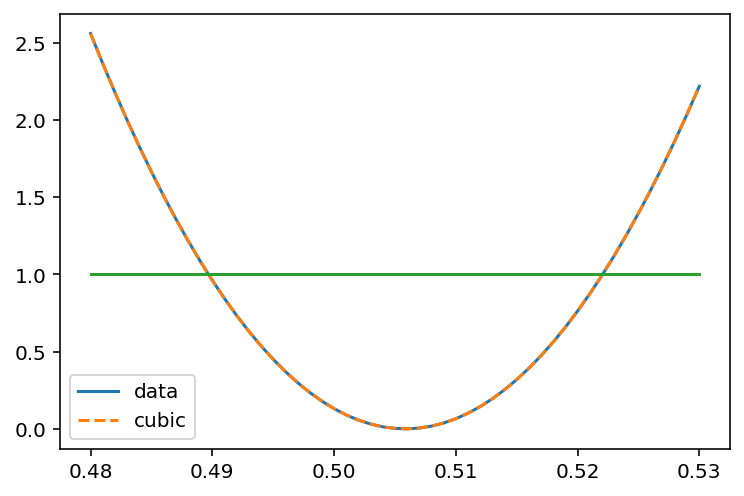

In [26]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')
plt.legend(['data', 'cubic'])

#CALCOLO DELL'ERRORE
xpoints= np.arange(0.48,0.53,0.001)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)



In [28]:
y2= lambda x: interpol(x) - 1 -chi2min
error1 = optimize.brentq(y2,0.48,0.5)    #trova le soluzioni in un intervallo fissato
error2 = optimize.brentq(y2,0.5,0.53)
print(error1,error2)

0.48968740672626077 0.5220541546392318


In [29]:
print(np.abs(min1-error1))
print(np.abs(min1-error2))

sigma = 0.02

0.016160371207221136
0.01620637670574987


In [ ]:
print("Il valore di gamma trovat è: ", round(min1,3) ," +- ", sigma)

Il valore di gamma trovat è:  0.549  +-  0.02


In [ ]:
#facciamo il fit, posso usare optimize perché ho l'errore su una sola variabile

#def func(i, gamma):
#    return (bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]
#
#index = np.array(0,len(kh),1)
#popt, pcov = optimize.curve_fit(func, index , Pgg[:,?], err_Pgg)  #non so che fare con ste mu
